Добавленные признаки:
   + количество ненормативной лексики
   + количество положительно окрашенных слов
   + количество отрицательно окрашенных слов 
   + количество подписчиков в паблике
   ------------------------------------
   Тексты лемматизированы

In [231]:
import numpy as np
import pandas as pd

In [232]:
data = pd.read_csv('data_preprocessed_final.csv', sep = '\t', encoding='cp1251')

In [233]:
y = data['LikesNormAvg'].astype(float)
true_likes = data['Likes'].astype(int)
coef = data['AvgLikes'].astype(float)/100
texts = data['Text']
lemtexts = data['LemText']
categ = data['Type']
followers = data['Followers']
X = data.drop(['Text','LikesNormAvg', 'LikesNormFlw', 'Likes', 'AvgLikes', 
       'GroupId', 'Date', 'LemText', 'Unnamed: 0', 'Type'], axis =1)

In [234]:
types = pd.get_dummies(categ)
X = pd.concat((X, types), axis = 1).astype(int)

In [235]:
def load_stop_words():
    file = open('../preprocessing/stop_words.txt', 'r')
    lines = file.readlines()
    stop_words = []
    for line in lines:
        stop_words.append(line.strip())
    return stop_words

In [236]:
sw = load_stop_words()

In [237]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', stop_words=sw, lowercase=True, min_df = 2)

In [238]:
texts_tfidf = tfidf.fit_transform(lemtexts)

In [239]:
texts_tfidf.shape

(6689, 15572)

In [240]:
state = 27

In [241]:
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(n_splits = 5, random_state = state)

In [242]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils.validation import check_array as check_arrays
def quality(y_true, y_pred):
    print('MAE:')
    print(mean_absolute_error(y_true, y_pred))
    print('MSE:')
    print(mean_squared_error(y_true, y_pred))
    print('RMSE:')
    print(np.sqrt(mean_squared_error(y_true, y_pred)))
#     print('MAPE')
#     print (format(mean_absolute_percentage_error(y_true, y_pred), '.8f'))

In [243]:
import matplotlib.pyplot as plt
% matplotlib inline
def plot_error(y_true, y_pred):
    fig = plt.figure(figsize =  (15, 6))
    plt.plot(y_true, color = 'magenta', label = 'true')
    plt.plot(y_pred, color = 'grey', alpha = 0.8, label = 'predicted' )
    plt.legend()

In [244]:
from scipy.sparse import csr_matrix, hstack, vstack
X_sparse = csr_matrix(X)
X_all_sparse =  hstack((X_sparse, texts_tfidf))

## Random Forest 100

In [245]:
from sklearn.ensemble import RandomForestRegressor
frst = RandomForestRegressor(n_estimators = 100)

In [246]:
pred_raw = cross_val_predict(frst, X_all_sparse, y, cv = kf, verbose = 10, n_jobs = 2)

[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed: 14.1min remaining:  9.4min
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 20.2min finished


MAE:
42.9659589569
MSE:
5082.6343483
RMSE:
71.2925967286


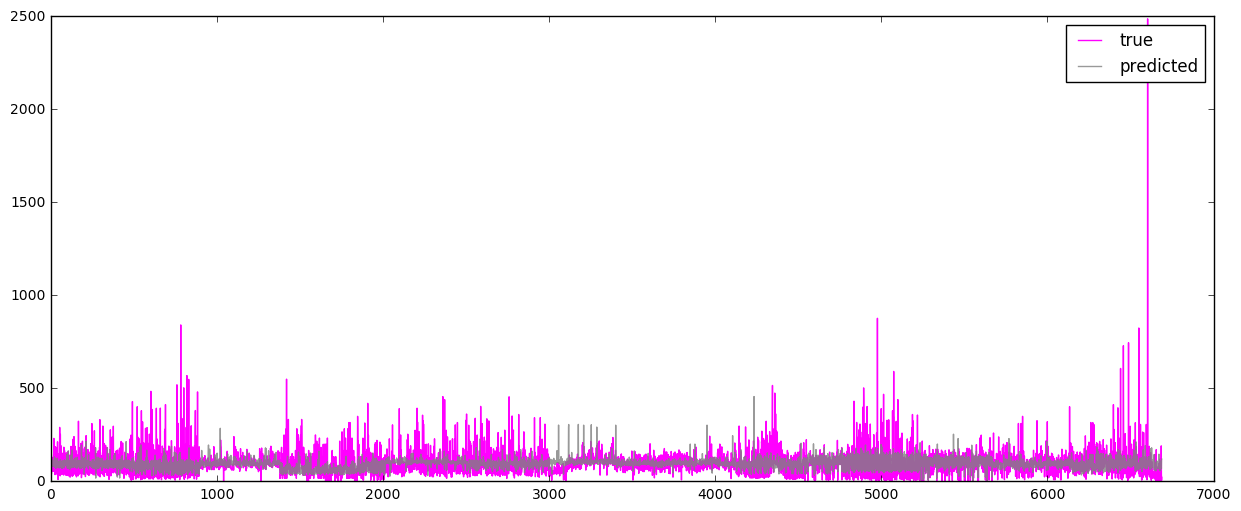

In [247]:
quality(y, pred_raw)
plot_error(y, pred_raw)

MAE:
1000.40535124
MSE:
6671529.29985
RMSE:
2582.93037069


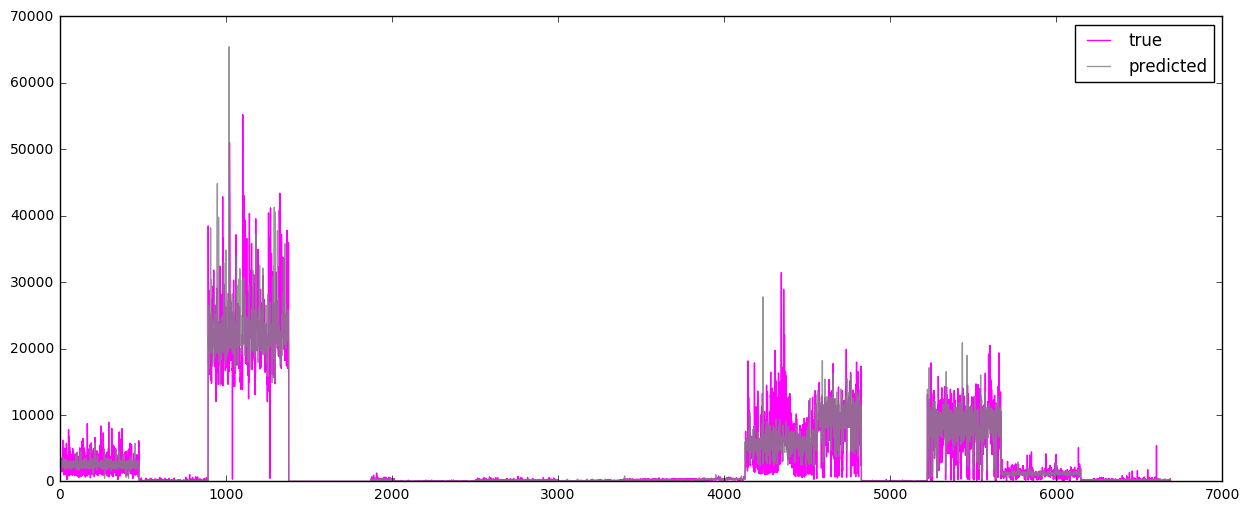

In [248]:
quality(true_likes, pred_raw*coef)
plot_error(true_likes, pred_raw*coef)

## KNN

In [249]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

In [250]:
pred_raw_knn = cross_val_predict(knn, X_all_sparse, y, cv = kf, verbose = 10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


MAE:
50.7790829276
MSE:
6424.91680183
RMSE:
80.1555787318


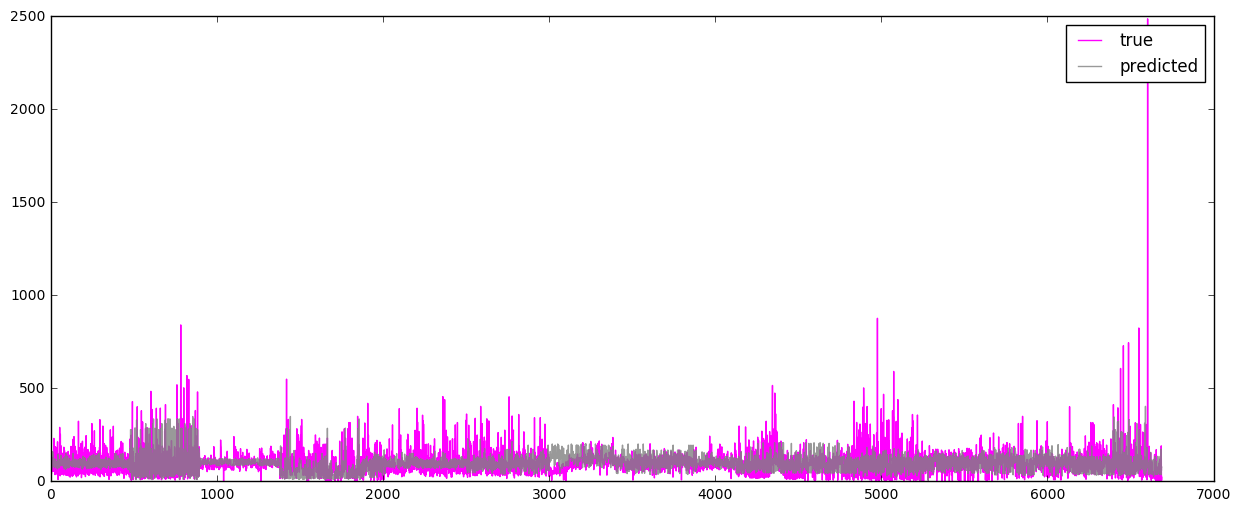

In [251]:
quality(y, pred_raw_knn)
plot_error(y, pred_raw_knn)

MAE:
1135.38393646
MSE:
7136549.59447
RMSE:
2671.43212425


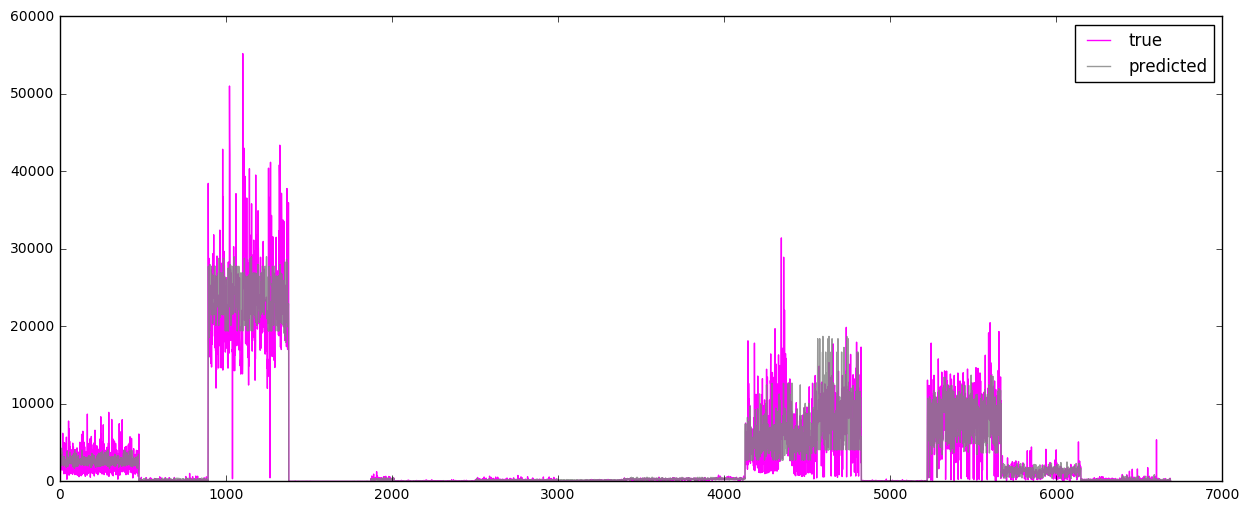

In [252]:
quality(true_likes, pred_raw_knn*coef)
plot_error(true_likes, pred_raw_knn*coef)

### Если отмасштабировать матрицу признаков

In [199]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer
scaler = StandardScaler(with_mean=False)
scaler.fit(X_all_sparse)
X_scaled = scaler.transform(X_all_sparse)

In [200]:
X_all_scaled = hstack((X_scaled, csr_matrix(followers.reshape((-1, 1)))))

In [201]:
pred_raw_knn_scaled = cross_val_predict(knn, X_all_scaled, y, cv = kf, verbose = 10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


MAE:
50.3058749914
MSE:
5776.35811341
RMSE:
76.0023559728


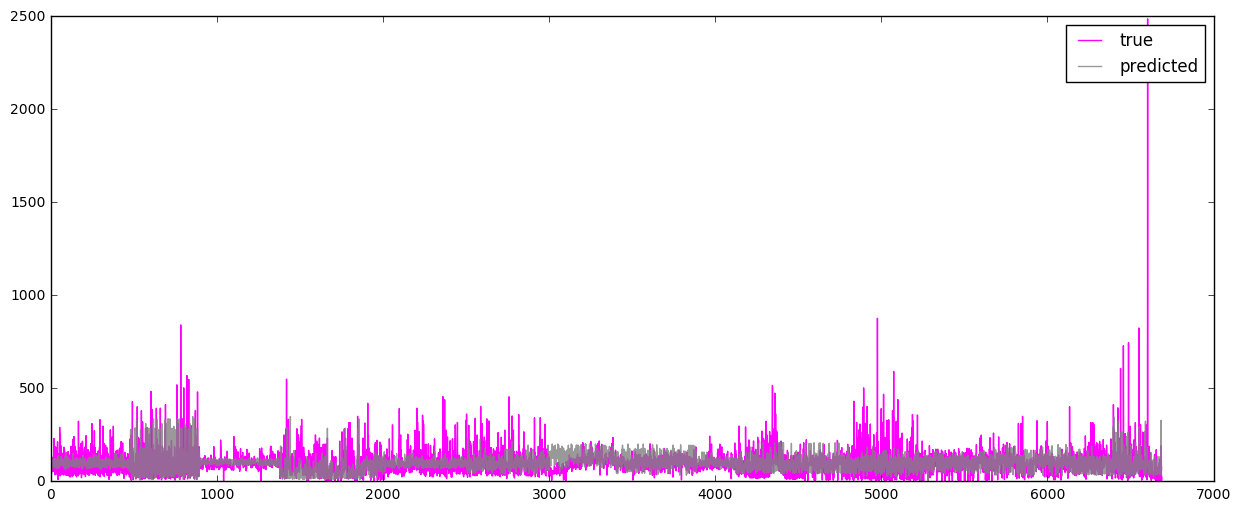

In [202]:
quality(y, pred_raw_knn_scaled)
plot_error(y, pred_raw_knn)

MAE:
1071.64538351
MSE:
6203534.44296
RMSE:
2490.6895517


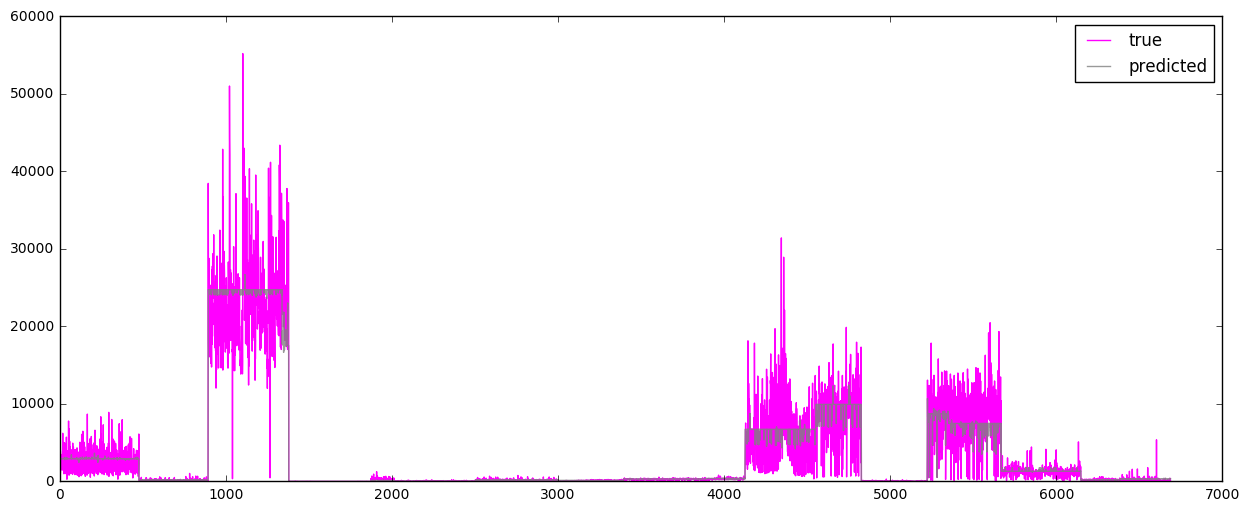

In [203]:
quality(true_likes, pred_raw_knn_scaled*coef)
plot_error(true_likes, pred_raw_knn_scaled*coef)

## Голосование

In [253]:
y_vote = pred_raw*0.7 + pred_raw_knn*0.3

MAE:
43.3135393015
MSE:
5091.40566118
RMSE:
71.3540865065


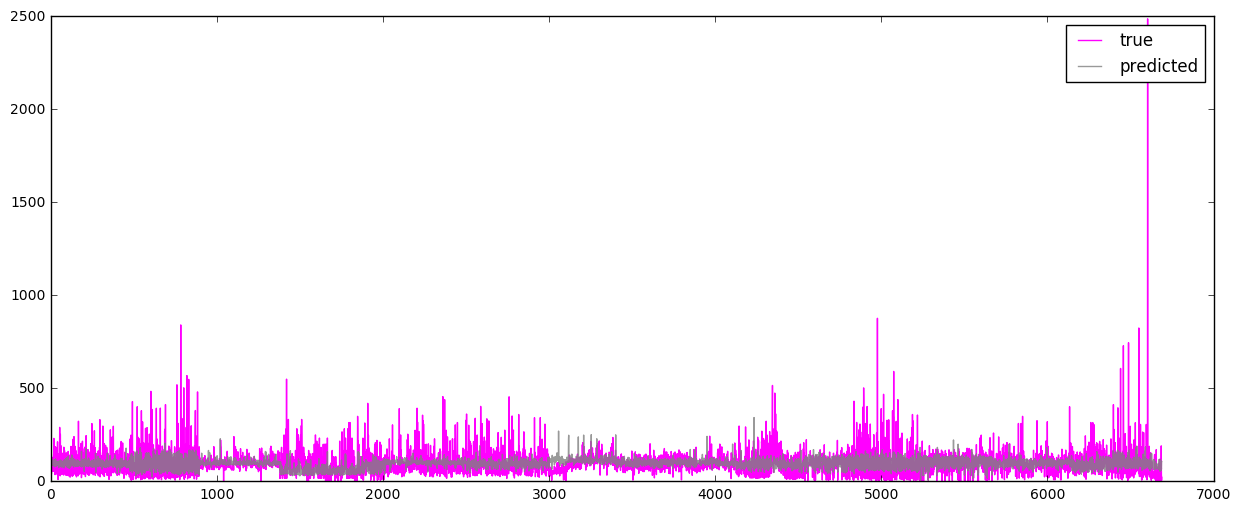

In [254]:
quality(y, y_vote)
plot_error(y, y_vote)

MAE:
988.107362294
MSE:
6064496.98107
RMSE:
2462.61994247


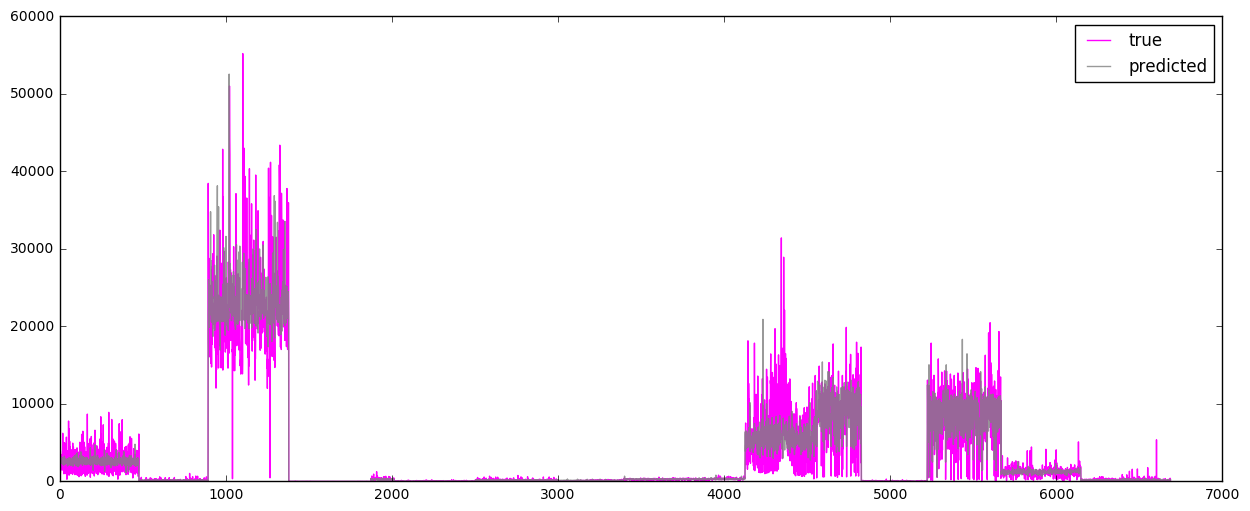

In [255]:
quality(true_likes, y_vote*coef)
plot_error(true_likes, y_vote*coef)

## Обучить и сохранить модели

In [256]:
frst.fit(X_all_sparse, y)
knn.fit(X_all_sparse, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [257]:
from sklearn.externals import joblib
knn_file = 'knn0.sav'
frst_file = 'frst0.sav'
joblib.dump(frst, frst_file)
joblib.dump(knn, knn_file)

['knn0.sav']